# <font color=green>deepBreaks Application</font>
Modeling the phenotypes and spectral tuning sites of opsin proteins based on amino-acid sequence... 

## <font color=red>Application Focus:</font> 
<font color=white>Phylogenetically Weighted Cross Validation Iteratative Testing</font>

**What factors are we interested in observing the effects of on model performance?**
* percentile threshold (aka - our desired minimum distance threshold)
* relation_mode handeling methods (leave_out, max_mean, merge, random) - How to handle nodes which fall below the distance threshold
* n_folds - How sensitive is this approach to differnt numbers of cross-validation folds? 
* tree models - How sensitive is this approach to different algorythms

**What is the best way to loop through these conditions?**
1. For each tree in a folder of trees (each constructed using a different algorythm)
2. For each relation handeling method 
3. For each n_folds in a range of fold numbers to test
4. For each percentile threshold in a range of desired thresholds to test
5. For each model algorythm in the deepBreaks pipeline
[Each subsequent number is nested in the previous - so for one tree we do all forms of relation handeling - and for all forms of relation handeling we go through all of a selected range of cv fold sizes and then we go through all percentile thresholds  in a list of percentile thresholds]

**What are the set paramaters or range of parameters we'll test as differnt conditions?**
* Tree Models / Tree Used - [for WT opsins] LG+F+R7 (top model), Q.pfam+F+R7, WAG+F+R7 // [for WT vert opsins] LG+F+R6, Q.pfam+F+R6, WAG+F+R6
* Relation Handeling Methods - leave_out, max_mean, merge, random
* Number of Folds - [5,8,10,12,15,20]
* Percentile Threshold Range - 1st -> 95th Percentiles - divied up into 40 percentile points in a list
* Normal selection of models from first round of training (pre-grid-search)

**General Workflow**
* Read a folders contents [should only contain phylogentic trees to test] and select a phylogentic tree file
* Load target phylogentic tree (_should be based on corresponding fasta file of sequence data_)
* Create new folder speific to testing that phylogentic tree - can use the name as the basis for naming the new folder - including the date and time
* Create either a new excel compatible csv file for recording the results of each test iteration or seperate excel files by number of folds, recording all upstream information about the test conditions in the file name and/or in some section of the excel/csv file. from each round of testing we should group results by Tree used (can be tree file name), then by relation handeling method, then by number of folds and then by model, and the corresponding R^2 value for a given threshold. (My end goal is to be able to graph all these different conditions).
NOTE - Following each round of model training the results are recorded in a csv file named 'model_report.csv' - we'll need to extract the R^2 values for each model from that column. On the first run we'll aslo need to extract all the model names so we can add them to the results file where we're recording model performance vs. threshold. 


In [1]:
#loading neccessary vpod scripts for phylogenetic cross validation
from vpod_scripts.phylo_weighted_cv import get_dist_matrix_from_tree, percentile_threshold, phylo_weighted_cv

# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, make_pipeline
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare
from deepBreaks.preprocessing import read_data
from deepBreaks.models import model_compare_cv
from deepBreaks.preprocessing import write_fasta
import warnings
import datetime
import os
import shutil 
import numpy as np

warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [2]:
# defining user params, file pathes, analysis type

#assign your path to folder containing all the datasplits
path = './vpod_1.2_data_splits_2024-08-20_16-14-09'
# path to sequences of interest
seqFileName = f'{path}/wt_vert_aligned_VPOD_1.2_het.fasta' 
# path to corresponding metadata of interest
metaDataFileName = f'{path}/wt_vert_meta.tsv' 

# name of the phenotype
mt = 'Lambda_Max'

# type of the sequences
seq_type = 'aa'

# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'reg' 

gap_threshold = 0.50

#Whether or not you want to drop the reference sequence from the training data- Usually 'Bovine' or 'Squid'
drop_ref = False

# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('/')[2]
#print(seqFile)
seqFile = seqFile.split('.')[0]+ '.'+ seqFile.split('.')[1]
#print(seqFile)
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [3]:
%%time
print('reading meta-data')
# importing metadata
meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
# importing sequences data
print('reading fasta file')

tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=gap_threshold)

shutil.copy2(f'{seqFileName}',report_dir)
write_fasta(dat = tr, fasta_file = f'{seqFile}_gap_dropped.fasta' , report_dir = report_dir)

tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True)

reading meta-data
reading fasta file
wt_vert_aligned_VPOD_1.2_het_gap_dropped.fasta was saved successfully
CPU times: total: 141 ms
Wall time: 144 ms


In [4]:
# Parameters and Conditions to Test
relation_handling_methods = ["leave_out", "max_mean", "merge", "random"]

n_folds_range = [5, 8, 10, 12, 15, 20]
percentile_threshold_range = list(range(1, 96, int(95 / 40))) # Generate 40 percentile points
tree_folder = "c:/Users/safra/Documents/GitHub/visual-physiology-opsin-db/scripts_n_notebooks/vpod_ML_workflows/subtests/work_in_progress/phylo_weighted_cv/opsin_vert_wt_tree/vpod_1.2"

In [5]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.05)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.025)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.1, keep=False)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.01, keep=False))
    ])

In [6]:
for tree_file in os.listdir(tree_folder):
    if tree_file.endswith(".treefile"): # Process only tree files
        # Load phylogenetic tree and obtain pair-wise distance matrix
        tree_path = os.path.join(tree_folder, tree_file)
        dist_matrix, tip_names = get_dist_matrix_from_tree(tree_path)
        
        # Create new folder for results
        timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        results_folder = f"{tree_file.split('.')[0]}.{tree_file.split('.')[1]}_phylo_cv_{timestamp}"
        os.makedirs(results_folder, exist_ok=True)

        # Create results file (choose CSV or Excel based on your preference)
        results_file = os.path.join(results_folder, f"{tree_file.split('.')[0]}.{tree_file.split('.')[1]}_phylo_cv_results.csv")
        with open(results_file, "w") as f:
            f.write("Tree,Relation_Handling,N_Folds,Model,Threshold,R2,MAE,MAPE,MSE,RMSE\n") # Header

        for relation_method in relation_handling_methods:
            for n_folds in n_folds_range:
                for percentile in percentile_threshold_range:
                    percentile_dist_threshold = percentile_threshold(dist_matrix, percentile=percentile)
                    tip_to_fold = phylo_weighted_cv(distance_matrix=dist_matrix, tip_names=tip_names, n_folds=n_folds, distance_threshold=percentile_dist_threshold, relation_mode=relation_method)
                    tr_temp = tr.copy()
                    tr_temp = tr_temp.reindex(tip_to_fold.index)
                    tr_temp['Fold'] = tip_to_fold['Fold']
                    if relation_method == 'leave_out':
                        tr_temp = tr_temp[tr_temp['Fold'] != -1]
                    tr_phylo_folds = tr_temp['Fold'].tolist()
                    tr_temp.drop('Fold', axis=1, inplace=True)
                    y = tr_temp.loc[:, mt].values
                    tr_temp.drop(mt, axis=1, inplace=True)
                    
                    if tr_temp.shape[0] > 100:
                        # Run deepBreaks pipeline (assuming necessary functions exist)
                        report, top = model_compare_cv(X=tr_temp, y=y, preprocess_pipe=prep_pipeline,
                                models_dict=get_models(ana_type=ana_type),
                                scoring=get_scores(ana_type=ana_type),
                                report_dir=report_dir,
                                cv=tr_phylo_folds, ana_type=ana_type, cache_dir=report_dir)
                        # Record R^2 values for each model
                        with open(results_file, "a") as f:
                            for model_name, r2_value, mae_value, mape_value, mse_value, rmse_value in zip(report.index.to_list(), report["R2"],report["MAE"],report["MAPE"],report["MSE"],report["RMSE"]):
                                f.write(f"{tree_file},{relation_method},{n_folds},{model_name},{percentile},{r2_value},{mae_value},{mape_value},{mse_value},{rmse_value}\n")
                        #removing the default model report file between iterations
                        os.remove(f'{report_dir}/model_report.csv')
                        shutil.rmtree(f'{report_dir}/joblib')
                    else:
                        continue


Fitting rf...
Fitting Adaboost...
Fitting et...
Fitting gbr...
Fitting dt...
Fitting lr...
Fitting Lasso...
Fitting LassoLars...
Fitting BayesianRidge...
Fitting HubR...
Fitting lgbm...
Fitting xgb...
Fitting rf...
Fitting Adaboost...
Fitting et...
Fitting gbr...
Fitting dt...
Fitting lr...
Fitting Lasso...
Fitting LassoLars...
Fitting BayesianRidge...
Fitting HubR...
Fitting lgbm...
Fitting xgb...
Fitting rf...
Fitting Adaboost...
Fitting et...
Fitting gbr...
Fitting dt...
Fitting lr...
Fitting Lasso...
Fitting LassoLars...
Fitting BayesianRidge...
Fitting HubR...
Fitting lgbm...
Fitting xgb...
Fitting rf...
Fitting Adaboost...
Fitting et...
Fitting gbr...
Fitting dt...
Fitting lr...
Fitting Lasso...
Fitting LassoLars...
Fitting BayesianRidge...
Fitting HubR...
Fitting lgbm...
Fitting xgb...
Fitting rf...
Fitting Adaboost...
Fitting et...
Fitting gbr...
Fitting dt...
Fitting lr...
Fitting Lasso...
Fitting LassoLars...
Fitting BayesianRidge...
Fitting HubR...
Fitting lgbm...
Fitting xg

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

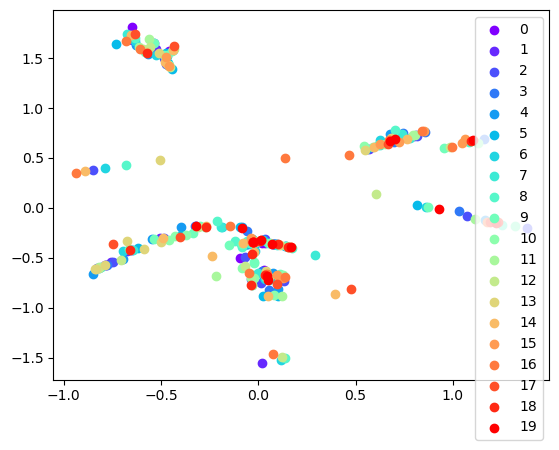

In [8]:
# Multidimensional scaling (MDS) to project points onto a 2D plane
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
pos = mds.fit_transform(dist_matrix)

# Unique labels and corresponding colors
unique_labels = list(set(tip_to_fold['Fold'].tolist()))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# Plot points with colors based on labels
for label, color in zip(unique_labels, colors):
    indices = [i for i, l in enumerate(tip_to_fold['Fold'].tolist()) if l == label]
    plt.scatter(pos[indices, 0], pos[indices, 1], color=color, label=label)

plt.legend()
#plt.title('Visualization of Points with Colors')
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D
# Enable interactive mode 
%matplotlib widget
# Multidimensional scaling for 3D visualization
mds = MDS(n_components=3, dissimilarity='precomputed', random_state=0)
pos = mds.fit_transform(dist_matrix)

# Unique labels and colors (same as before)
#unique_labels = list(set(labels))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# 3D plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for label, color in zip(unique_labels, colors):
    indices = [i for i, l in enumerate(tip_to_fold['Fold'].tolist()) if l == label]
    ax.scatter(pos[indices, 0], pos[indices, 1], pos[indices, 2], color=color, label=label)

ax.legend()
#plt.title('3D Visualization of Points with Colors')

plt.show()

ModuleNotFoundError: No module named 'ipympl'